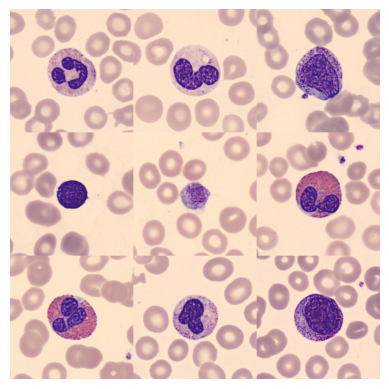

Selected labels for the collage:  ['neutrophil', 'neutrophil', 'ig', 'lymphocyte', 'platelet', 'eosinophil', 'eosinophil', 'neutrophil', 'ig']


In [1]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt

def create_collage(image_dir, grid_size=(3, 3), image_size=(224, 224)):
    class_folders = os.listdir(image_dir)
    selected_images = []
    selected_labels = []

    rows, cols = grid_size
    
    for _ in range(rows * cols):
        random_class = random.choice(class_folders)
        class_path = os.path.join(image_dir, random_class)

        image_filename = random.choice(os.listdir(class_path))
        image_path = os.path.join(class_path, image_filename)
        
        image = cv2.imread(image_path)
        image = cv2.resize(image, image_size)
        
        selected_images.append(image)
        selected_labels.append(random_class)
    collage = np.zeros((image_size[0] * rows, image_size[1] * cols, 3), dtype=np.uint8)

    for i in range(rows):
        for j in range(cols):
            idx = i * cols + j
            collage[i * image_size[0]:(i + 1) * image_size[0], j * image_size[1]:(j + 1) * image_size[1]] = selected_images[idx]

    return collage, selected_labels

image_directory = '/kaggle/input/microscopic-peripheral-blood-cell-images/PBC_dataset_normal_DIB'

collage_image, selected_labels = create_collage(image_directory, grid_size=(3, 3), image_size=(224, 224))
cv2.imwrite('collage_image.png', collage_image)  # You can save the image
plt.imshow(cv2.cvtColor(collage_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

print("Selected labels for the collage: ", selected_labels)

In [2]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import numpy as np

model = models.mobilenet_v2(pretrained=False)
model.classifier[1] = nn.Linear(model.last_channel, 8)  # Assuming 8 classes

model.load_state_dict(torch.load('/kaggle/input/96.59_mobilenet_v2/pytorch/default/1/96.59_mobilenet_v2.pth', map_location=torch.device('cpu')))

model.eval()

preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/tmp/ipykernel_17/3128918.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions t

In [3]:
def split_collage(image, grid_size):
    img_width, img_height = image.size
    sub_img_width = img_width // grid_size[1]
    sub_img_height = img_height // grid_size[0]
    
    sub_images = []
    for row in range(grid_size[0]):
        for col in range(grid_size[1]):
            left = col * sub_img_width
            top = row * sub_img_height
            right = (col + 1) * sub_img_width
            bottom = (row + 1) * sub_img_height
            sub_img = image.crop((left, top, right, bottom))
            sub_images.append(sub_img)
    
    return sub_images

def classify_collage(image_path, grid_size, selected_labels):
    image = Image.open(image_path).convert('RGB')
    sub_images = split_collage(image, grid_size)
    
    predictions = []
    sub_images_with_text = []
    
    for idx, sub_img in enumerate(sub_images):
        input_tensor = preprocess(sub_img)
        input_batch = input_tensor.unsqueeze(0)
        input_batch = input_batch.to(next(model.parameters()).device)
        
        with torch.no_grad():
            output = model(input_batch)
        _, predicted_idx = torch.max(output, 1)
        predictions.append(predicted_idx.item())
        
        sub_img_cv = np.array(sub_img)
        sub_img_cv = cv2.cvtColor(sub_img_cv, cv2.COLOR_RGB2BGR)
        
        predicted_class_name = full_dataset[predicted_idx.item()]
        actual_class_name = selected_labels[idx]  # Get the actual class

        # Write predicted and actual class names on the sub-image
        cv2.putText(sub_img_cv, predicted_class_name, (10, 30), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)
        cv2.putText(sub_img_cv, actual_class_name, (10, 60), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)  # Green color for actual class
        
        sub_images_with_text.append(sub_img_cv)
    
    return predictions, sub_images_with_text

In [4]:
def rebuild_collage(sub_images_with_text, grid_size):
    rows, cols = grid_size
    sub_img_height, sub_img_width, _ = sub_images_with_text[0].shape
    
    collage = np.zeros((rows * sub_img_height, cols * sub_img_width, 3), dtype=np.uint8)
    
    idx = 0
    for i in range(rows):
        for j in range(cols):
            collage[i * sub_img_height:(i + 1) * sub_img_height, 
                    j * sub_img_width:(j + 1) * sub_img_width] = sub_images_with_text[idx]
            idx += 1
    
    return collage

def display_image(image):
    # Convert BGR (OpenCV format) to RGB for displaying with matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)
    plt.axis('off')  # Hide axis
    plt.show()

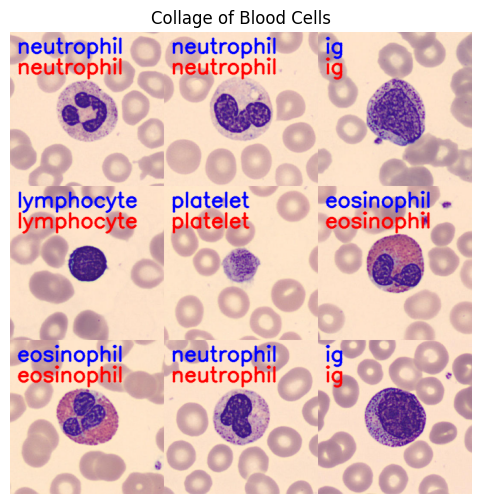

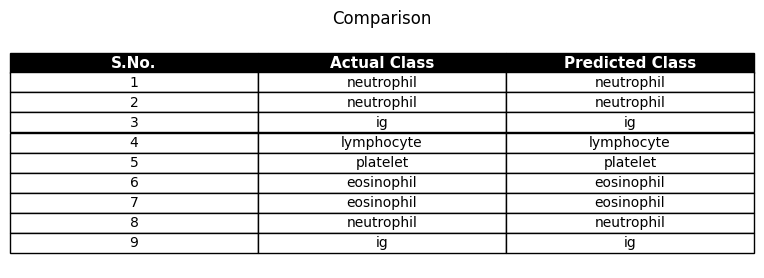

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2

collage_path = '/kaggle/working/collage_image.png'
grid_size = (3, 3)
full_dataset = ['basophil', 'eosinophil', 'erythroblast', 'ig', 'lymphocyte', 'monocyte', 'neutrophil', 'platelet']

predicted_classes, sub_images_with_text = classify_collage(collage_path, grid_size, selected_labels)

final_collage = rebuild_collage(sub_images_with_text, grid_size)

cv2.imwrite('/kaggle/working/final_collage_with_labels_and_legend.png', final_collage)

data = {
    "S.No.": [i for i in range(1, 10)],
    "Actual Class": selected_labels,
    "Predicted Class": [full_dataset[i] for i in predicted_classes]
}
df = pd.DataFrame(data)

plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(final_collage, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Collage of Blood Cells')
plt.show()

plt.figure(figsize=(8, 3))
plt.axis('tight')
plt.axis('off')

tbl = plt.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')

tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1.2, 1.2)

header = tbl[0, 0]
for j in range(len(df.columns)):
    cell = tbl[0, j]
    cell.set_fontsize(11)
    cell.set_text_props(weight='bold', color='white')
    cell.set_facecolor('black')

plt.title('Comparison', pad=10)
plt.show()
